In [11]:
ROOT = ".." # Adjust to repository root

import os, random, re, math, json
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
DATA_ROOT = Path(os.path.join(ROOT, 'datasets', 'daep'))
assert DATA_ROOT.exists(), "Place the extracted dataset under ../datasets"

# List all files in DATA_ROOT
print(f"Files in {DATA_ROOT}:")
for item in DATA_ROOT.iterdir():
    if item.is_file():
        print(f"  File: {item.name}")
    elif item.is_dir():
        print(f"  Directory: {item.name}")
        # List files in the subdirectory
        for subitem in item.iterdir():
            if subitem.is_file():
                print(f"    - {subitem.name}")

Files in ..\datasets\daep:
  File: Additional_Information_by_Country.csv
  File: Australia_AEMO_2006.csv
  File: Australia_AEMO_2007.csv
  File: Australia_AEMO_2008.csv
  File: Australia_AEMO_2009.csv
  File: Australia_AEMO_2010.csv
  File: Australia_AEMO_2011.csv
  File: Australia_AEMO_2012.csv
  File: Australia_AEMO_2013.csv
  File: Australia_AEMO_2014.csv
  File: Australia_AEMO_2015.csv
  File: Australia_AEMO_2016.csv
  File: Australia_AEMO_2017.csv
  File: Australia_AEMO_2018.csv
  File: Australia_AEMO_2019.csv
  File: Australia_AEMO_2020.csv
  File: Australia_AEMO_2021.csv
  File: Australia_AEMO_2022.csv
  File: Australia_AEMO_2023.csv
  File: Australia_AEMO_2024.csv
  File: Australia_AEMO_2025.csv
  File: Austria_ENTSO-E_2015.csv
  File: Austria_ENTSO-E_2016.csv
  File: Austria_ENTSO-E_2017.csv
  File: Austria_ENTSO-E_2018.csv
  File: Austria_ENTSO-E_2019.csv
  File: Austria_ENTSO-E_2020.csv
  File: Austria_ENTSO-E_2021.csv
  File: Austria_ENTSO-E_2022.csv
  File: Austria_ENTSO-E

In [17]:
# --- 1.1 Pick one country and one CSV (based on specified year)
def list_country_year_files(root: Path, country: str = None):
    out = []
    country_filter = country.lower() if country else None

    for f in sorted(root.glob("*.csv")):
        stem = f.stem
        if country_filter and country_filter not in stem.lower():
            continue

        if country:
            country_name = country
        else:
            tokens = [tok for tok in re.split(r"[_\W]+", stem) if tok]
            country_name = next((tok for tok in tokens if tok.isalpha()), stem)

        out.append((country_name, f))
    return out

COUNTRY = "Spain"
YEAR = 2018
files = list_country_year_files(root = DATA_ROOT, country=COUNTRY)
assert files, "No CSV files found under the dataset root."

# Find the file that contains the specified YEAR in its filename
found = False
for i, (country_name, path) in enumerate(files):
    if str(YEAR) in path.name:
        country = country_name
        file_path = path
        found = True
        break

assert found, f"No file found for year {YEAR}"
country, file_path

('Spain', WindowsPath('../datasets/daep/Spain_ENTSO-E_2018.csv'))

In [18]:
def load_series_any(file_path: Path):
    df = pd.read_csv(file_path)
    # Timestamp candidates (dataset uses 'Timestamp' in many CSVs)
    ts_candidates = [c for c in df.columns if str(c).lower() in 
                     ("timestamp","time","datetime","date","mtu","mtu_start")]
    assert ts_candidates, f"No timestamp column found in {file_path.name}"
    ts = ts_candidates[0]
    df[ts] = pd.to_datetime(df[ts], utc=True, errors="coerce")
    df = df.dropna(subset=[ts]).sort_values(ts)

    # Choose a single price column among non-time columns
    non_time = [c for c in df.columns if c != ts]
    # heuristic: prefer columns with 'price', 'da', 'lmp', 'lbmp'
    pref = [c for c in non_time if re.search(r"(price|da|lmp|lbmp)", str(c).lower())]
    cand_cols = pref or non_time
    # remove obviously non-numeric columns
    cand_cols = [c for c in cand_cols if pd.api.types.is_numeric_dtype(df[c])]
    assert cand_cols, f"No numeric price column candidates found in {file_path.name}"
    price_col = cand_cols[0]

    s = df.set_index(ts)[price_col].astype(float).sort_index()
    # enforce hourly frequency
    s = s.asfreq("H")

    # neighbor-average imputation (paper): x_t = (x_{t-1}+x_{t+1})/2  (with edge ffill/bfill)
    def avg_neighbor_fill(x):
        x = x.copy()
        for _ in range(4):
            mask = x.isna()
            if not mask.any(): break
            x[mask] = (x.shift(1)[mask] + x.shift(-1)[mask]) / 2.0
        return x.ffill().bfill()
    s = avg_neighbor_fill(s)

    return pd.DataFrame({"price": s})

raw = load_series_any(file_path)
raw.head(), raw.index.min(), raw.index.max(), raw.shape

(                           price
 Timestamp                       
 2018-01-01 00:00:00+00:00   6.74
 2018-01-01 01:00:00+00:00   4.74
 2018-01-01 02:00:00+00:00   3.66
 2018-01-01 03:00:00+00:00   2.30
 2018-01-01 04:00:00+00:00   2.30,
 Timestamp('2018-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2018-12-31 23:00:00+0000', tz='UTC'),
 (8760, 1))

In [19]:
def temporal_train_test_split(df):
    years = sorted(df.index.year.unique())
    if len(years) >= 2:
        train = df[df.index.year.isin(years[:-1])]
        test  = df[df.index.year == years[-1]]
    else:
        # fallback: last 20% as test
        split = int(len(df)*0.8)
        train, test = df.iloc[:split], df.iloc[split:]
    return train, test

train_df, test_df = temporal_train_test_split(raw)
train_df.shape, test_df.shape, (train_df.index.min(), train_df.index.max()), (test_df.index.min(), test_df.index.max())

((7008, 1),
 (1752, 1),
 (Timestamp('2018-01-01 00:00:00+0000', tz='UTC'),
  Timestamp('2018-10-19 23:00:00+0000', tz='UTC')),
 (Timestamp('2018-10-20 00:00:00+0000', tz='UTC'),
  Timestamp('2018-12-31 23:00:00+0000', tz='UTC')))

2) Exploratory sanity checks

Why: visual checks reveal seasonality/trend and detect bad gaps before modeling. The paper uses seasonal/decomposition visualizations to justify later design choices. 

Enhanced_Transformer-BiLSTM_Dee…

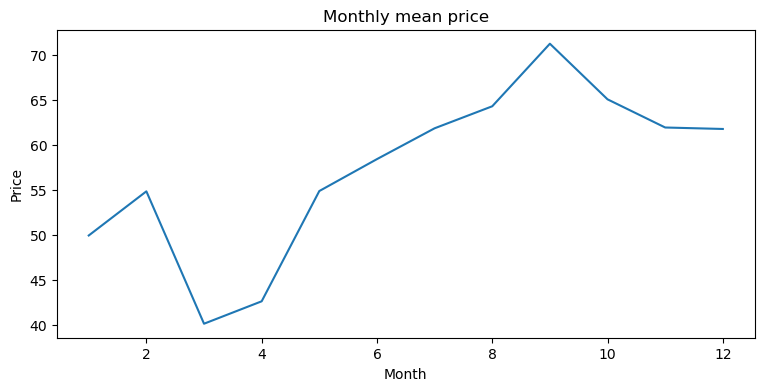

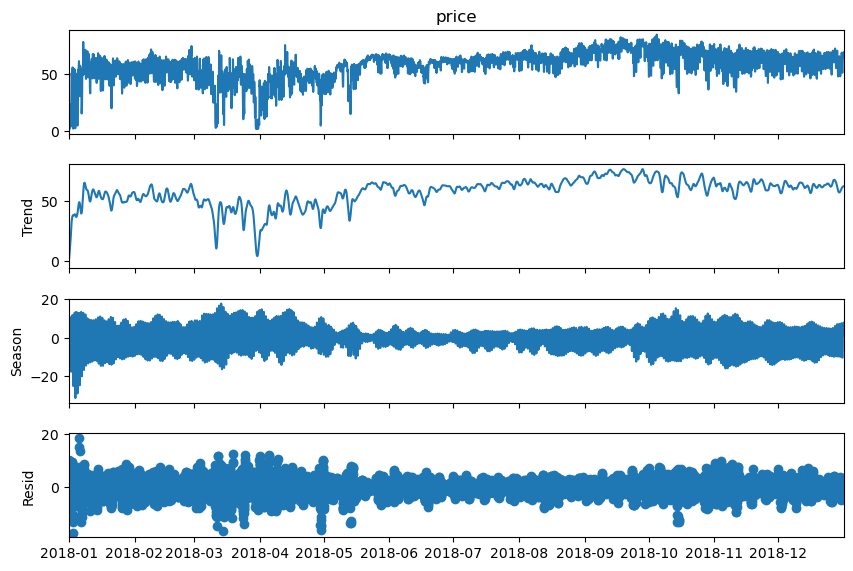

In [20]:
monthly = raw["price"].groupby([raw.index.year, raw.index.month]).mean().unstack(0)
ax = monthly.plot(figsize=(9,4), legend=False)
ax.set_title("Monthly mean price")
ax.set_xlabel("Month"); ax.set_ylabel("Price")
plt.show()

from statsmodels.tsa.seasonal import STL
s = raw["price"].dropna()
s_recent = s.iloc[-24*365*2:] if len(s) > 24*365*2 else s
res = STL(s_recent, period=24).fit()
fig = res.plot(); fig.set_size_inches(9,6); plt.show()

3) Scaling and sliding windows (as in Algorithm 1)

Min–Max to [0,1] improves numerical stability; sliding window builds (X, y) where X covers the past T_lag hours and y the next T hours (direct multi-step). 

Enhanced_Transformer-BiLSTM_Dee…

In [21]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paper defaults
T_LAG = 60      # past hours used as input features
T = 1           # forecast horizon (hours ahead)
LR = 1e-3
BATCH = 32
EPOCHS = 50


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[["price"]])
test_scaled  = scaler.transform(test_df[["price"]])

def make_windows(a2d, lag=T_LAG, horizon=T):
    X, y = [], []
    N = len(a2d)
    for start in range(0, N - lag - horizon + 1):
        X.append(a2d[start:start+lag])
        y.append(a2d[start+lag:start+lag+horizon, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = make_windows(train_scaled, T_LAG, T)
X_test,  y_test  = make_windows(test_scaled,  T_LAG, T)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6948, 60, 1), (6948, 1), (1692, 60, 1), (1692, 1))

4) Model: Transformer encoder → BiLSTM (paper’s hybrid)

Architecture (paper): Positional Encoding → [LayerNorm → Multi-Head Attention → Dropout] → [LayerNorm → FFN(ReLU) → Dropout] → BiLSTM(64×2) → Dense(128, ReLU) → Dropout(0.1) → Dense(T, linear). Trained with Adam LR=1e-3, batch=32. 

Enhanced_Transformer-BiLSTM_Dee…

In [8]:
# 4.1 Positional encoding (sinusoidal) as used in Transformer
class SinePositionalEncoding(layers.Layer):
    def __init__(self, d_model): 
        super().__init__(); self.d_model = d_model
    def call(self, x):
        L = tf.shape(x)[1]
        pos = tf.cast(tf.range(L)[:, None], tf.float32)
        i   = tf.cast(tf.range(self.d_model)[None, :], tf.float32)
        angle = pos / tf.pow(10000.0, (2*(i//2))/self.d_model)
        s = tf.sin(angle[:, 0::2]); c = tf.cos(angle[:, 1::2])
        pe = tf.reshape(tf.stack([s, c], axis=-1), (L, -1))
        pe = pe[None, :, :self.d_model]
        return x + pe

In [9]:
# 4.2 One transformer encoder block (LayerNorm -> MHA -> Dropout -> residual; then FFN -> Dropout -> residual)
def transformer_encoder_block(x, heads=4, key_dim=64, ff_dim=128, drop=0.1, eps=1e-6):
    a = layers.LayerNormalization(epsilon=eps)(x)
    a = layers.MultiHeadAttention(num_heads=heads, key_dim=key_dim)(a, a)
    a = layers.Dropout(drop)(a)
    x = layers.Add()([x, a])
    f = layers.LayerNormalization(epsilon=eps)(x)
    f = layers.Dense(ff_dim, activation="relu")(f)
    f = layers.Dropout(drop)(f)
    x = layers.Add()([x, f])
    return x

In [10]:
# 4.3 Assemble hybrid
def build_transformer_bilstm(input_len=T_LAG, horizon=T, d_model=64,
                             heads=4, key_dim=64, ff_dim=None, lstm_units=64,
                             drop=0.1, lr=LR):
    if ff_dim is None:
        ff_dim = d_model  # Ensure output shape matches input shape for residual connection
    inp = keras.Input(shape=(input_len,1))
    x = layers.Dense(d_model)(inp)
    x = SinePositionalEncoding(d_model)(x)
    x = transformer_encoder_block(x, heads, key_dim, ff_dim, drop)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(drop)(x)
    out = layers.Dense(horizon, activation="linear")(x)
    m = keras.Model(inp, out, name="Transformer_BiLSTM")
    m.compile(optimizer=keras.optimizers.Adam(lr), loss="mse")
    return m

model = build_transformer_bilstm()
model.summary()

Model: "Transformer_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 64)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 60, 64)    │          0 │ dense[0][0]       │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ sine_positional_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ sine_positional_… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 64)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ add_1[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,601 (600.00 KB)

 Trainable params: 153,601 (600.00 KB)

 Non-trainable params: 0 (0.00 B)

5) Training protocol

Early stopping on val loss; batch 32; epochs up to 50 (plateaus ~20–30 in the paper’s curves). 

Enhanced_Transformer-BiLSTM_Dee…

In [13]:
cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
hist = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[cb],
    verbose=1
)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0727 - val_loss: 0.0140
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 

6) Evaluation: MAE, RMSE, MAPE, sMAPE, R² (paper’s metrics)

Definitions and metric set follow the paper exactly. 

Enhanced_Transformer-BiLSTM_Dee…

In [14]:
def rmse(a,b): return np.sqrt(np.mean((a-b)**2))
def mape(y, yhat): return np.mean(np.abs((y - yhat) / np.maximum(1e-8, np.abs(y)))) * 100
def smape(y, yhat):
    denom = (np.abs(y) + np.abs(yhat))/2.0
    return np.mean(np.abs(y - yhat) / np.maximum(1e-8, denom)) * 100

# Predict
yhat_s = model.predict(X_test, verbose=0)

# Invert scaling to native units
def invert_scale(arr2d):
    flat = arr2d.reshape(-1,1)
    inv  = scaler.inverse_transform(flat).reshape(arr2d.shape)
    return inv

y_true = invert_scale(y_test)
y_hat  = invert_scale(yhat_s)

MAE  = mean_absolute_error(y_true.ravel(), y_hat.ravel())
RMSE = rmse(y_true.ravel(), y_hat.ravel())
MAPE = mape(y_true.ravel(), y_hat.ravel())
SMAPE= smape(y_true.ravel(), y_hat.ravel())
R2   = r2_score(y_true.ravel(), y_hat.ravel())

{
  "MAE": round(MAE,4),
  "RMSE": round(RMSE,4),
  "MAPE_%": round(MAPE,4),
  "sMAPE_%": round(SMAPE,4),
  "R2": round(R2,4)
}

{'MAE': 7.4808,
 'RMSE': 11.0581,
 'MAPE_%': 86284837.5,
 'sMAPE_%': 29.9945,
 'R2': 0.9292}

Quick visual.

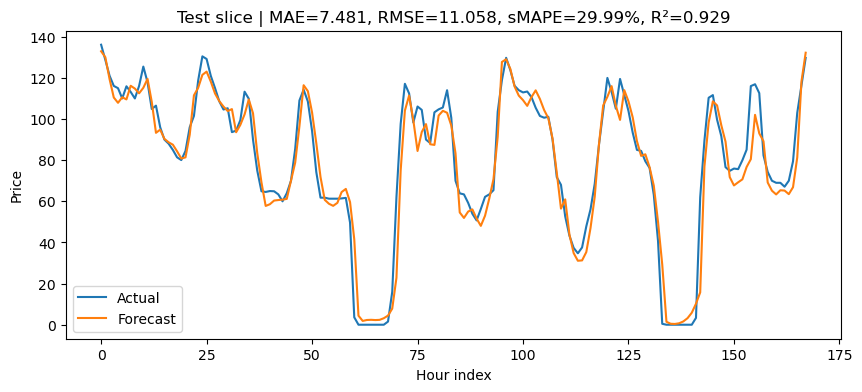

In [15]:
n = min(24*7, len(y_true))  # a week
plt.figure(figsize=(10,4))
plt.plot(y_true[:n,0], label="Actual")
plt.plot(y_hat[:n,0],  label="Forecast")
plt.title(f"Test slice | MAE={MAE:.3f}, RMSE={RMSE:.3f}, sMAPE={SMAPE:.2f}%, R²={R2:.3f}")
plt.xlabel("Hour index"); plt.ylabel("Price"); plt.legend(); plt.show()

7) Compact baselines (context from the paper’s comparisons)

The paper compared many models and showed the hybrid on top; to keep this runnable, two light baselines are provided: a BiLSTM-only and a Transformer-only. Train/evaluate with the same windows/metrics cells to obtain a local table akin to the paper’s. 

Enhanced_Transformer-BiLSTM_Dee…

In [16]:
def bilstm_baseline(input_len=T_LAG, units=64, horizon=T, drop=0.1):
    inp = keras.Input(shape=(input_len,1))
    x = layers.Bidirectional(layers.LSTM(units))(inp)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(drop)(x)
    out = layers.Dense(horizon)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss="mse")
    return m

def transformer_baseline(input_len=T_LAG, d_model=64, heads=4, key_dim=64, ff_dim=128, drop=0.1, horizon=T):
    inp = keras.Input(shape=(input_len,1))
    x = layers.Dense(d_model)(inp)
    x = SinePositionalEncoding(d_model)(x)
    x = transformer_encoder_block(x, heads, key_dim, ff_dim, drop)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(drop)(x)
    out = layers.Dense(horizon)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss="mse")
    return m


10) Minimal “press go” cell (end-to-end)

In [17]:
# Rebuild, train, score — quick runner
model = build_transformer_bilstm(input_len=T_LAG, horizon=T)
cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
_ = model.fit(X_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[cb], verbose=1)

yhat_s = model.predict(X_test, verbose=0)
y_true = invert_scale(y_test); y_hat = invert_scale(yhat_s)

def summarize(y_true, y_hat):
    MAE  = mean_absolute_error(y_true.ravel(), y_hat.ravel())
    RMSE = rmse(y_true.ravel(), y_hat.ravel())
    MAPE = mape(y_true.ravel(), y_hat.ravel())
    SMAPE= smape(y_true.ravel(), y_hat.ravel())
    R2   = r2_score(y_true.ravel(), y_hat.ravel())
    return {"MAE": round(MAE,3), "RMSE": round(RMSE,3),
            "MAPE_%": round(MAPE,2), "sMAPE_%": round(SMAPE,2), "R2": round(R2,3)}

summarize(y_true, y_hat)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0893 - val_loss: 0.0087
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 

{'MAE': 7.51,
 'RMSE': 10.681,
 'MAPE_%': 264430825.0,
 'sMAPE_%': 29.76,
 'R2': 0.934}